In [111]:
#Imports
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

#Config / Settings
BASE = Path(r"C:\Users\damen\Desktop\football-main")

PROJ_DIR = BASE / "Projections"
ACT_DIRS = {
    'QB': BASE / r"Actuals\QB Stats",
    'RB': BASE / r"Actuals\RB Stats",
    'WR': BASE / r"Actuals\WR Stats",
    'TE': BASE / r"Actuals\TE Stats",
}

YEARS = range(2018, 2025)
POSITIONS = ['QB', 'RB', 'WR', 'TE']

#Season game counts for divisor (schedule length)
SEASON_GAMES = {
    2018: 16, 2019: 16, 2020: 16,
    2021: 17, 2022: 17, 2023: 17, 2024: 17    
}

# Projections (stack + filter + season)
def load_projections(position: str, years=YEARS) -> pd.DataFrame:
    """
    Load and stack projection data for a given position across multiple seasons.

    Reads CSVs from the 'Projections' folder, filters to the target position,
    adds season info, and standardizes player names.
    Returns one combined DataFrame.
    """
    frames = []
    for y in years:
        df = pd.read_csv(PROJ_DIR / f"projections_{y}_wk0.csv")[['player','position','points']].copy()
        df['season'] = y
        df['player'] = df['player'].astype(str).str.strip()
        df = df[df['position'].str.upper() == position]
        frames.append(df)
    return pd.concat(frames, ignore_index=True)

# Actuals (stack + strip team from name + season)
def load_actuals(position: str, years=YEARS) -> pd.DataFrame:
    """
    Load and stack actual fantasy stats for a given position across multiple seasons.

    Reads CSVs from the 'Actuals' folder, removes team name tags from player names,
    keeps only player and FPTS (total points), adds season and position info,
    and returns a combined DataFrame.
    """
    frames = []
    for y in years:
        df = pd.read_csv(ACT_DIRS[position] / f"{y} {position} Stats", sep=None, engine='python')
        df = df.rename(columns={'Player':'player'})[['player','FPTS']].copy()
        df['player'] = (
            df['player'].astype(str)
            .str.replace(r"\s*\([^)]*\)$", "", regex=True)  # strip (TEAM)
            .str.strip()
        )
        df['season'] = y
        df['position'] = position
        frames.append(df)
    return pd.concat(frames, ignore_index=True)


def build_panel(position: str) -> pd.DataFrame:
    """
    Build a merged panel of projected vs actual fantasy points for one position.

    Loads both projections and actuals, joins on player and season,
    renames columns for clarity, and calculates:
      - error (proj - actual)
      - error_pct (error as % of projection)
    Returns the merged and annotated DataFrame.
    """
    proj = load_projections(position)
    act = load_actuals(position)

    panel = (
        proj.merge(
            act[['player', 'season', 'FPTS']],
            on=['player', 'season'],
            how='inner'
        )
        .rename(columns={'points': 'proj_points', 'FPTS': 'actual_FPTS'})
    )
    panel['error'] = panel['proj_points'] - panel['actual_FPTS']
    panel['error_pct'] = panel['error'] / panel['proj_points']
    return panel

def build_ppg_panel(position: str) -> pd.DataFrame:
    """
    Build a per-game projection panel for one position.

    Loads projections and actuals, including FPTS/G and games played,
    cleans and merges them by player and season,
    and calculates:
      - proj_ppg: projected points per game (based on season length)
      - actual_ppg: actual points per game (from source data)
      - ppg_error: difference between projected and actual PPG
    """
    def _norm(s: str) -> str:
        return s.upper().replace(' ', '').replace('/', '').replace('_', '')

    # Load projections
    proj_frames = []
    for y in YEARS:
        dfp = pd.read_csv(PROJ_DIR / f"projections_{y}_wk0.csv")[['player','position','points']].copy()
        dfp['season'] = y
        dfp['player'] = dfp['player'].astype(str).str.strip()
        dfp = dfp[dfp['position'].str.upper() == position]
        proj_frames.append(dfp)
    proj_all = pd.concat(proj_frames, ignore_index=True)

    # Load actuals
    act_frames = []
    for y in YEARS:
        dfa = pd.read_csv(ACT_DIRS[position] / f"{y} {position} Stats", sep=None, engine='python')
        cols = { _norm(c): c for c in dfa.columns }
        player_col = cols.get('PLAYER', 'Player')
        fpts_col   = cols.get('FPTS',   'FPTS')
        fptsg_col  = cols.get('FPTSG',  'FPTS/G')
        g_col      = cols.get('G',      'G')

        dfa = dfa[[player_col, fpts_col, fptsg_col, g_col]].copy()
        dfa.columns = ['player','FPTS','FPTS_per_G','G']
        dfa['player'] = (
            dfa['player'].astype(str).str.strip()
            .str.replace(r"\s*\([^)]*\)$", "", regex=True)
        )
        dfa['season'] = y
        dfa['position'] = position
        act_frames.append(dfa)

    act_all = pd.concat(act_frames, ignore_index=True)

    # Merge and calculate PPG
    panel = (
        proj_all.merge(
            act_all[['player','season','FPTS','FPTS_per_G','G']],
            on=['player','season'],
            how='inner'
        )
        .rename(columns={'points':'proj_points', 'FPTS':'actual_FPTS'})
    )
    panel['proj_ppg']   = panel.apply(lambda r: r['proj_points'] / SEASON_GAMES[int(r['season'])], axis=1)
    panel['actual_ppg'] = pd.to_numeric(panel['FPTS_per_G'], errors='coerce')
    panel['ppg_error']  = panel['proj_ppg'] - panel['actual_ppg']

    return panel

def build_all_ppg_panels(positions=POSITIONS) -> pd.DataFrame:
    """
    Build a combined per-game panel across all positions.

    Calls build_ppg_panel() for each position (QB, RB, WR, TE),
    and stacks the results into one DataFrame for summary analysis.
    """
    return pd.concat(
        [build_ppg_panel(pos) for pos in positions],
        ignore_index=True
    )


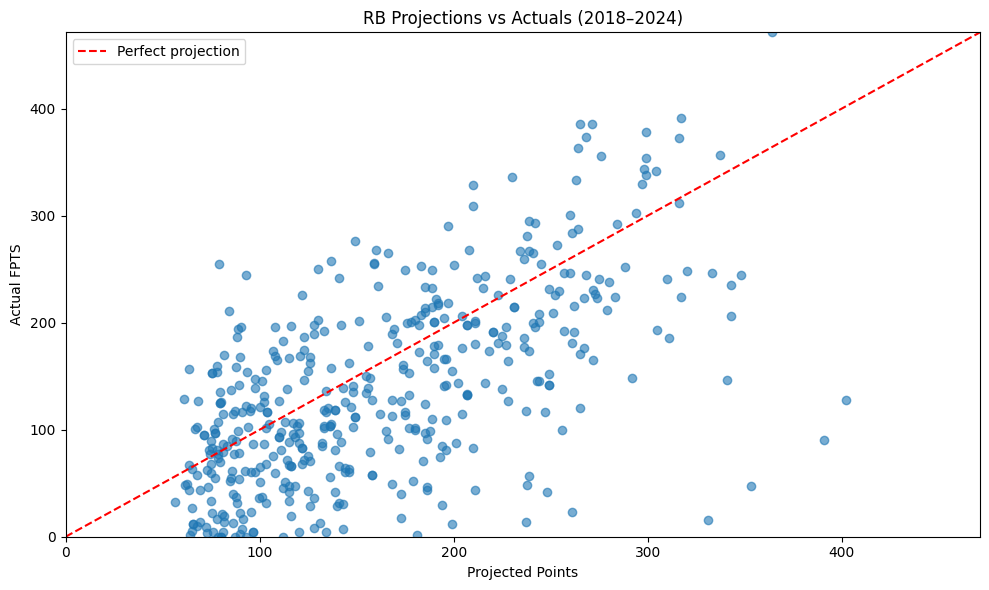

In [112]:
# SELECTOR
POSITION = 'RB'

# Build panel for this position
panel = build_panel(POSITION)


# === Total Points Scatter Plot ===
# Each dot is one player-season
# X-axis: Projected total points
# Y-axis: Actual total points
# Dashed red line shows perfect projection (x = y)


# Scatter: projections vs actuals
plt.figure(figsize=(10,6))
plt.scatter(panel['proj_points'], panel['actual_FPTS'], alpha=0.6)

# y = x line (perfect projection)
lims = [min(panel['proj_points'].min(), panel['actual_FPTS'].min()),
        max(panel['proj_points'].max(), panel['actual_FPTS'].max())]
plt.plot(lims, lims, 'r--', label='Perfect projection')

plt.xlim(lims)
plt.ylim(lims)
plt.xlabel('Projected Points')
plt.ylabel('Actual FPTS')
plt.title(f'{POSITION} Projections vs Actuals (2018–2024)')
plt.legend()
plt.tight_layout()
plt.show()

In [113]:
# SELECTOR
POSITION = 'RB'

# Build panel for this position
panel = build_panel(POSITION)
print(panel.columns)

# Sort largest to smallest error (over-projections)
panel_sorted = panel.sort_values('error', ascending=False)

# Show the 20 worst over-projections
print(f"\nWorst Over-Projections for {POSITION} (2018–2024):")
print(panel_sorted[['season','player','proj_points','actual_FPTS','error']].head(20))

Index(['player', 'position', 'proj_points', 'season', 'actual_FPTS', 'error',
       'error_pct'],
      dtype='object')

Worst Over-Projections for RB (2018–2024):
     season               player  proj_points  actual_FPTS  error
138    2020       Saquon Barkley        331.0         15.4  315.6
379    2024  Christian McCaffrey        353.0         47.8  305.2
137    2020  Christian McCaffrey        391.0         90.4  300.6
197    2021  Christian McCaffrey        402.0        127.5  274.5
321    2023           Nick Chubb        261.0         23.1  237.9
8      2018      Devonta Freeman        237.0         14.1  222.9
267    2022     Javonte Williams        248.0         42.0  206.0
256    2022      Jonathan Taylor        341.0        146.4  194.6
213    2021         Chris Carson        238.0         48.1  189.9
334    2023         J.K. Dobbins        199.0         11.7  187.3
389    2024        Isiah Pacheco        239.0         56.9  182.1
221    2021       Raheem Mostert        181

In [114]:
# SELECTOR
POSITION = 'RB'      
#Biggest under-projections (actual >> projected)
panel_sorted_under = panel.sort_values('error', ascending=True)

print(panel_sorted_under[['season','player','proj_points','actual_FPTS','error']].head(20))

     season               player  proj_points  actual_FPTS  error
373    2023       Kyren Williams         79.1        255.0 -175.9
426    2024         Bucky Irving         92.7        244.4 -151.7
30     2018          James White        149.0        276.6 -127.6
369    2023          Jerome Ford         84.0        211.2 -127.2
231    2021         James Conner        137.0        257.7 -120.7
6      2018  Christian McCaffrey        265.0        385.5 -120.5
170    2020       James Robinson        130.0        250.4 -120.4
273    2022          Josh Jacobs        210.0        328.3 -118.3
4      2018       Saquon Barkley        271.0        385.8 -114.8
347    2023       Raheem Mostert        160.0        267.7 -107.7
61     2019  Christian McCaffrey        364.0        471.2 -107.2
391    2024        Derrick Henry        230.0        336.4 -106.4
52     2018           Nick Chubb         88.6        194.5 -105.9
248    2021      Darrel Williams         90.3        196.0 -105.7
204    202

In [115]:
# SELECTOR
POSITION = 'WR'

# Build per-game panel
panel = build_ppg_panel(POSITION)

# Sort top 20 over and under projections
ppg_over = panel.sort_values('ppg_error', ascending=False).head(20)
ppg_under = panel.sort_values('ppg_error', ascending=True).head(20)

# Display side by side
from IPython.display import display, HTML

left_table = ppg_over[['season', 'player', 'proj_ppg', 'actual_ppg', 'ppg_error']].reset_index(drop=True)
right_table = ppg_under[['season', 'player', 'proj_ppg', 'actual_ppg', 'ppg_error']].reset_index(drop=True)

# Render tables side by side using HTML
html = f"""
<div style="display: flex; gap: 50px;">
  <div>
    <h3>Top 20 Over-Projections (PPG) – {POSITION}</h3>
    {left_table.to_html(index=False)}
  </div>
  <div>
    <h3>Top 20 Under-Projections (PPG) – {POSITION}</h3>
    {right_table.to_html(index=False)}
  </div>
</div>
"""

display(HTML(html))

season,player,proj_ppg,actual_ppg,ppg_error
2019,A.J. Green,12.937500,0.0,12.937500
2021,Curtis Samuel,11.705882,2.0,9.705882
2019,Donte Moncrief,9.562500,0.7,8.862500
2019,Donte Moncrief,9.562500,0.7,8.862500
2020,Michael Thomas,20.750000,12.0,8.750000
2024,John Stephens Jr.,8.529412,0.0,8.529412
2018,Mike Wallace,8.187500,0.0,8.187500
2018,Rishard Matthews,8.937500,0.9,8.037500
2019,JuJu Smith-Schuster,16.937500,9.4,7.537500
2021,Tyrell Williams,10.352941,3.4,6.952941


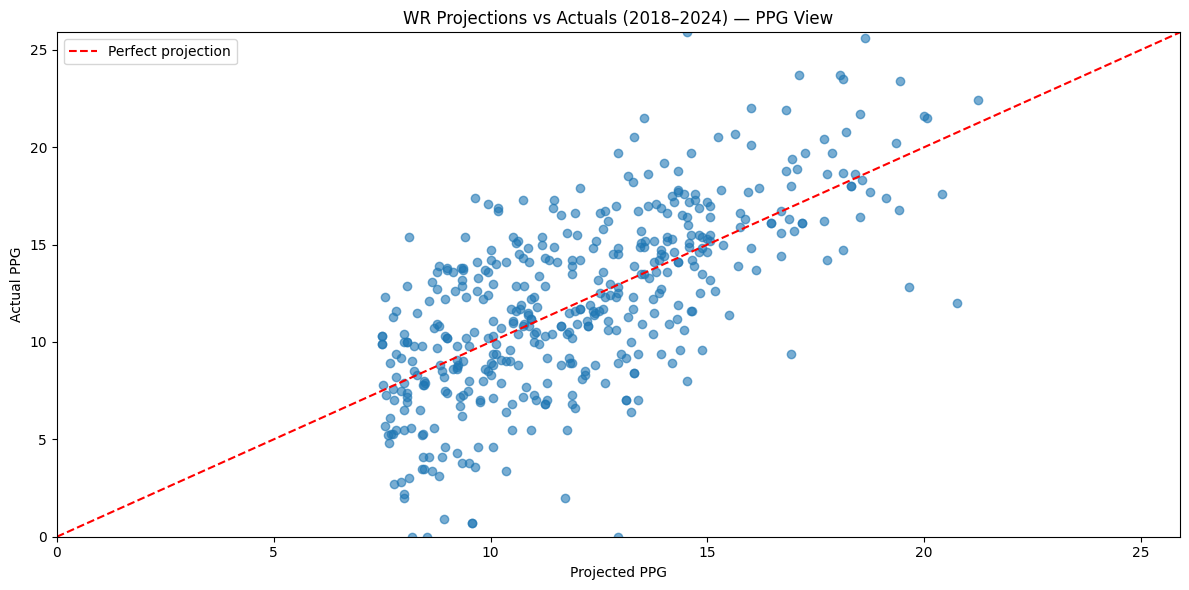

In [ ]:
# SELECTOR
POSITION = 'WR'

# Build PPG panel
panel = build_ppg_panel(POSITION)

# === Per-Game Scatter Plot ===
# Each dot = one player-season
# X-axis: Projected points per game (based on season length)
# Y-axis: Actual points per game (from FPTS/G column)
# Dashed red line = perfect projection (x = y)

# Scatter: projected PPG vs actual PPG
plt.figure(figsize=(12,6))
plt.scatter(panel['proj_ppg'], panel['actual_ppg'], alpha=0.6)

# y = x reference line
lims = [
    min(panel['proj_ppg'].min(), panel['actual_ppg'].min()),
    max(panel['proj_ppg'].max(), panel['actual_ppg'].max())
]
plt.plot(lims, lims, 'r--', label='Perfect projection')

plt.xlim(lims)
plt.ylim(lims)
plt.xlabel('Projected PPG')
plt.ylabel('Actual PPG')
plt.title(f'{POSITION} Projections vs Actuals (2018–2024) — PPG View')
plt.legend()
plt.tight_layout()
plt.show()

Projection Error Summary by Position (PPG view):
  position  avg_error  avg_abs_error
0       QB   1.494928       3.971062
1       RB  -0.426833       2.935345
2       WR  -0.005829       2.653603
3       TE   0.049196       2.383514


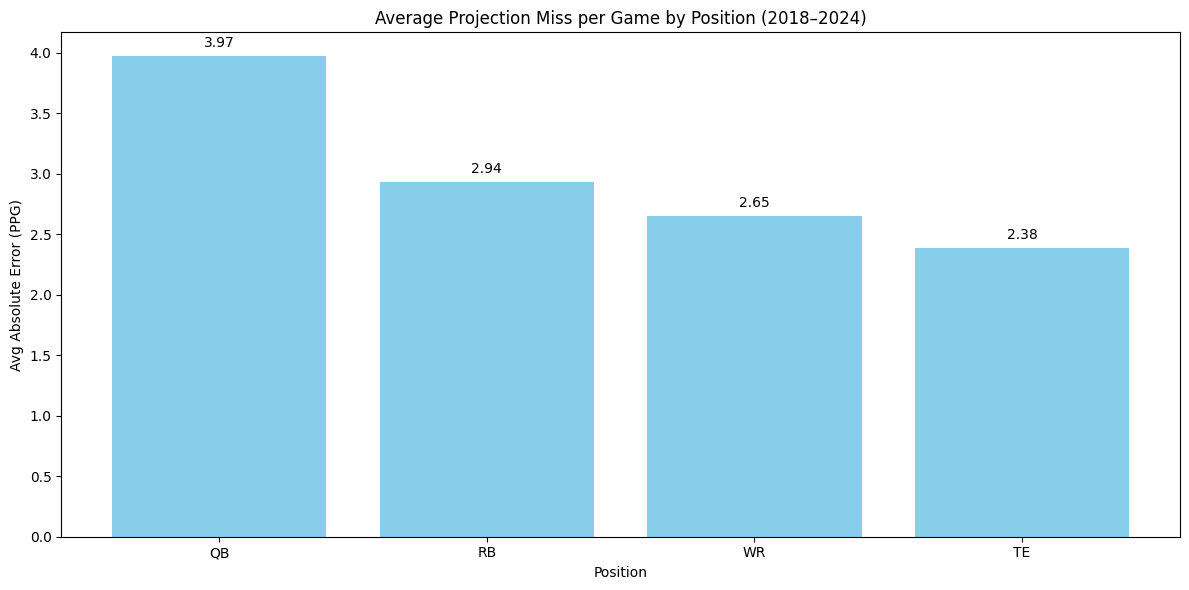

In [117]:
# Build all-position panel
panel_all = build_all_ppg_panels()

# Summary by position
summary = (
    panel_all.groupby('position')
             .agg(
                 avg_error=('ppg_error','mean'),
                 avg_abs_error=('ppg_error', lambda x: x.abs().mean())
             )
             .reindex(POSITIONS)  # enforce order
             .reset_index()
)

# Display
print("Projection Error Summary by Position (PPG view):")
print(summary)

# Chart
plt.figure(figsize=(12,6))
plt.bar(summary['position'], summary['avg_abs_error'], color='skyblue')
for i, v in enumerate(summary['avg_abs_error']):
    plt.text(i, v + 0.05, f"{v:.2f}", ha='center', va='bottom')

plt.title("Average Projection Miss per Game by Position (2018–2024)")
plt.ylabel("Avg Absolute Error (PPG)")
plt.xlabel("Position")
plt.tight_layout()
plt.show()

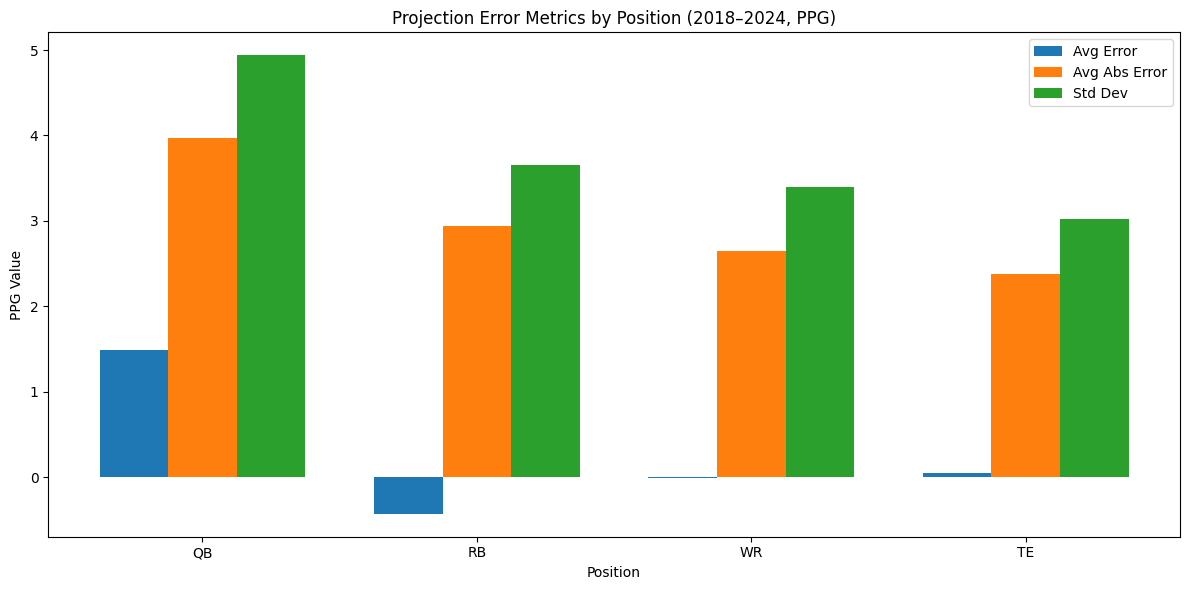

In [118]:
# SELECTOR — pull full summary again
panel_all = build_all_ppg_panels()

summary_full = (
    panel_all.groupby('position')
             .agg(
                 avg_error=('ppg_error','mean'),
                 avg_abs_error=('ppg_error', lambda x: x.abs().mean()),
                 std_dev=('ppg_error', 'std')
             )
             .reindex(POSITIONS)
             .reset_index()
)

# Plot grouped bar chart
metrics_to_plot = ['avg_error', 'avg_abs_error', 'std_dev']
bar_width = 0.25
x = range(len(POSITIONS))

plt.figure(figsize=(12,6))

for i, metric in enumerate(metrics_to_plot):
    offset = [xi + bar_width * i for xi in x]
    plt.bar(offset, summary_full[metric], width=bar_width, label=metric.replace('_', ' ').title())

# Fix x-axis
midpoints = [xi + bar_width for xi in x]
plt.xticks(midpoints, POSITIONS)
plt.title('Projection Error Metrics by Position (2018–2024, PPG)')
plt.ylabel('PPG Value')
plt.xlabel('Position')
plt.legend()
plt.tight_layout()
plt.show()

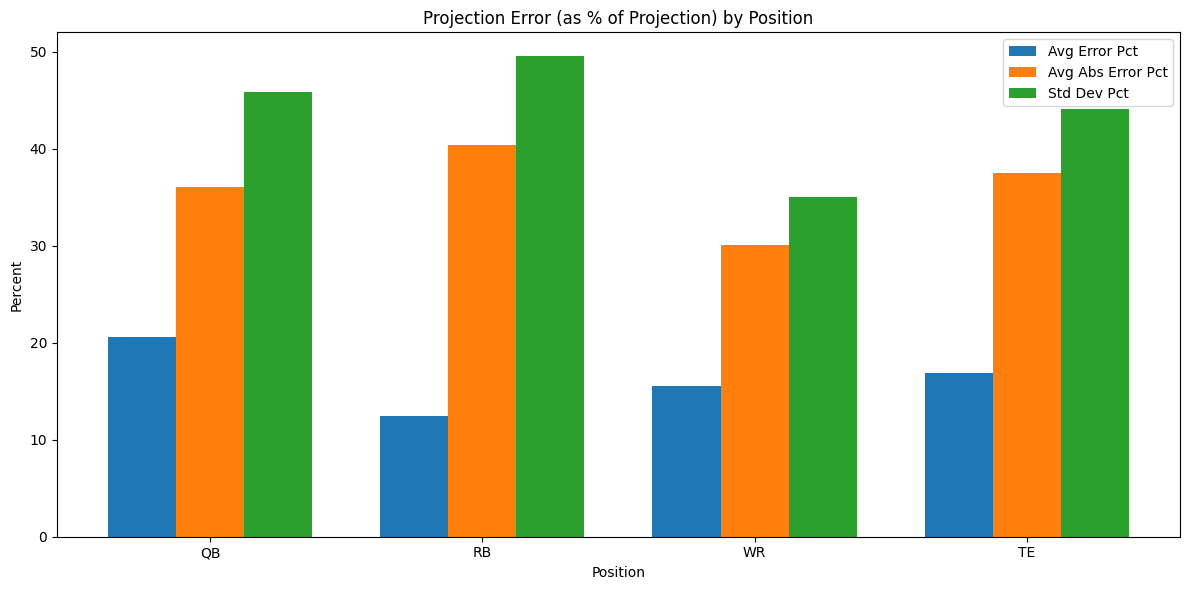

In [119]:
# Build panel with percent error
panel_all = build_all_total_panels()

# Group by position and summarize percent error
summary_pct = (
    panel_all.groupby('position')
             .agg(
                 avg_error_pct=('error_pct','mean'),
                 avg_abs_error_pct=('error_pct', lambda x: x.abs().mean()),
                 std_dev_pct=('error_pct', 'std')
             )
             .reindex(POSITIONS)
             .reset_index()
)

# Convert to percentages
summary_pct[['avg_error_pct', 'avg_abs_error_pct', 'std_dev_pct']] *= 100

# Plot grouped bar chart
metrics = ['avg_error_pct', 'avg_abs_error_pct', 'std_dev_pct']
bar_width = 0.25
x = range(len(POSITIONS))

plt.figure(figsize=(12,6))

for i, metric in enumerate(metrics):
    offset = [xi + bar_width * i for xi in x]
    plt.bar(offset, summary_pct[metric], width=bar_width, label=metric.replace('_', ' ').title())

# Fix x-axis
midpoints = [xi + bar_width for xi in x]
plt.xticks(midpoints, POSITIONS)
plt.title('Projection Error (as % of Projection) by Position')
plt.ylabel('Percent')
plt.xlabel('Position')
plt.legend()
plt.tight_layout()
plt.show()